In [2]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

: 

: 

In [4]:
df = pd.read_csv('./data/airline_sentiment_analysis.csv')
print(np.sum(df.isnull().any(axis=1)))
df.head()

0


,Unnamed: 0,airline_sentiment,text
0,1,positive,@VirginAmerica plus you've added commercials t...
1,3,negative,@VirginAmerica it's really aggressive to blast...
2,4,negative,@VirginAmerica and it's a really big bad thing...
3,5,negative,@VirginAmerica seriously would pay $30 a fligh...
4,6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [5]:
print('Lenght of dataset', len(df))
df.info

Lenght of dataset 11541


<bound method DataFrame.info of        Unnamed: 0 airline_sentiment  \
0               1          positive   
1               3          negative   
2               4          negative   
3               5          negative   
4               6          positive   
...           ...               ...   
11536       14633          negative   
11537       14634          negative   
11538       14635          positive   
11539       14636          negative   
11540       14638          negative   

                                                    text  
0      @VirginAmerica plus you've added commercials t...  
1      @VirginAmerica it's really aggressive to blast...  
2      @VirginAmerica and it's a really big bad thing...  
3      @VirginAmerica seriously would pay $30 a fligh...  
4      @VirginAmerica yes, nearly every time I fly VX...  
...                                                  ...  
11536  @AmericanAir my flight was Cancelled Flightled...  
11537         @AmericanAir 

In [44]:
flags = []
for ind in df.index:
    fla = (1 if df['airline_sentiment'][ind]== 'positive' else 0)
    flags.append(fla)
df['flags'] = flags
df.head()

,Unnamed: 0,airline_sentiment,text,flags
0,1,positive,@VirginAmerica plus you've added commercials t...,1
1,3,negative,@VirginAmerica it's really aggressive to blast...,0
2,4,negative,@VirginAmerica and it's a really big bad thing...,0
3,5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
4,6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


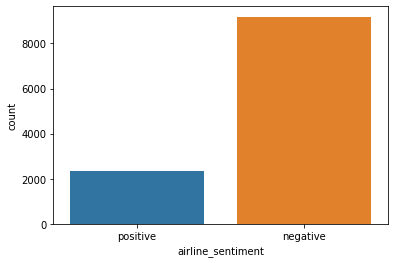

In [45]:
sns.countplot(x='airline_sentiment', data=df)

In [46]:
data = df[['text', 'airline_sentiment']]
data['airline_sentiment'].unique()
data['airline_sentiment'].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [47]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

In [48]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

def cleaning_stopwords(text):
  #remove the stop words from the text
  return " ".join([word for word in str(text).split() if word not in STOPWORDS])


def cleaning_repeating_char(text):
  #remove the repitative characters from the text
  return re.sub(r'(.)1+', r'1', text)

english_punctuations = string.punctuation
punctuations_list = english_punctuations

def cleaning_punctuations(text):
  #removes punctuations like ! or @ from the text
  translator = str.maketrans('', '', punctuations_list)
  return text.translate(translator)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
train_df['text']=train_df['text'].str.lower()
train_df['text'] = train_df['text'].apply(lambda text: cleaning_stopwords(text))
train_df['text'] = train_df['text'].apply(lambda x: cleaning_repeating_char(x))
train_df['text']= train_df['text'].apply(lambda x: cleaning_punctuations(x))

train_df.head()

,text,airline_sentiment
7150,usairways another dead end handle aa lampf gav...,negative
8316,usairways 2066 plane pbi clt knew frozen water...,negative
8331,usairways waiting bags 25min phl bag claim,negative
7767,usairways never heard back would help chance c...,negative
916,united thanks,positive


In [50]:
test_df['text']=test_df['text'].str.lower()
test_df['text'] = test_df['text'].apply(lambda text: cleaning_stopwords(text))
test_df['text'] = test_df['text'].apply(lambda x: cleaning_repeating_char(x))
test_df['text']= test_df['text'].apply(lambda x: cleaning_punctuations(x))

test_df.head()

,text,airline_sentiment
9193,usairways charged flight cancelled flightled u...,negative
6112,jetblue great flight great view httptcoyxn00p...,positive
967,united theyre not actually gate agent rude sta...,negative
11279,americanair worries called back 4 hrs late fli...,negative
3061,united thank you one months ago none now weird...,positive


In [51]:
senti_lab = train_df.airline_sentiment.factorize()
senti_lab

(array([0, 0, 0, ..., 1, 0, 0]),
 Index(['negative', 'positive'], dtype='object'))

In [52]:
text = train_df.text.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(text)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(text)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [53]:
print(text[0])
print(encoded_docs[0])

usairways another dead end handle aa lampf gave failed  already had 10362749899 vm full lost
[3, 72, 1460, 454, 539, 143, 3430, 321, 720, 137, 974, 4924, 3431, 274, 71]


# Training

In [54]:
# Save checkpoints during training
checkpoint_path = "sentiment_analysis/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=2*batch_size)

In [62]:
def create_model():
  embedding_vector_length = 32
  model = Sequential() 
  model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
  model.add(SpatialDropout1D(0.25))
  model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid')) 
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
  print(model.summary()) 
  return model

In [63]:
model = create_model()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 200, 32)           411456    
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 428,107
Trainable params: 428,107
Non-trainable params: 0
________________________________________________

In [56]:
model.save_weights(checkpoint_path.format(epoch=0))

In [57]:
prediction = model.fit(padded_sequence,senti_lab[0],validation_split=0.2, epochs=5, batch_size=32, callbacks=[cp_callback])

Epoch 1/5
 63/231 [=======>......................] - ETA: 43s - loss: 0.5563 - accuracy: 0.7907
Epoch 1: saving model to sentiment_analysis/cp-0001.ckpt
127/231 [===============>..............] - ETA: 26s - loss: 0.5110 - accuracy: 0.7972
Epoch 1: saving model to sentiment_analysis/cp-0001.ckpt
191/231 [=======================>......] - ETA: 10s - loss: 0.4664 - accuracy: 0.8087
Epoch 1: saving model to sentiment_analysis/cp-0001.ckpt
231/231 [==============================] - 66s 271ms/step - loss: 0.4439 - accuracy: 0.8176 - val_loss: 0.3085 - val_accuracy: 0.8738
Epoch 2/5
 24/231 [==>...........................] - ETA: 53s - loss: 0.2713 - accuracy: 0.8984
Epoch 2: saving model to sentiment_analysis/cp-0002.ckpt
 88/231 [==========>...................] - ETA: 36s - loss: 0.2533 - accuracy: 0.9027
Epoch 2: saving model to sentiment_analysis/cp-0002.ckpt
152/231 [==================>...........] - ETA: 20s - loss: 0.2370 - accuracy: 0.9104
Epoch 2: saving model to sentiment_analysis/c

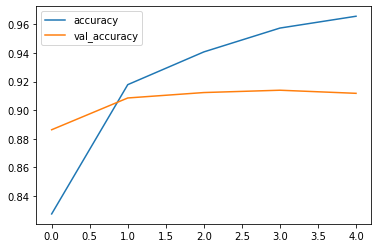

<Figure size 432x288 with 0 Axes>

In [25]:
plt.plot(prediction.history['accuracy'], label='accuracy')
plt.plot(prediction.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.savefig('./results/accuracy plot.jpg')


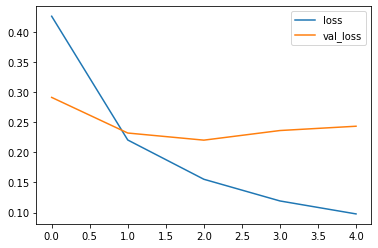

<Figure size 432x288 with 0 Axes>

In [26]:
plt.plot(prediction.history['loss'], label='loss')
plt.plot(prediction.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("./results/Loss plot.jpg")

# Inference

In [58]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'sentiment_analysis/cp-0005.ckpt'

In [64]:
model = create_model()

model.load_weights(latest)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 200, 32)           411456    
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_8 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 428,107
Trainable params: 428,107
Non-trainable params: 0
________________________________________________

In [65]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", senti_lab[1][prediction])

In [32]:
count = 0
for index in test_df.index:
  # print(test_df['text'][index])
  text = test_df['text'][index]
  res = predict_sentiment(text)
  print("Actual Label: ", test_df['airline_sentiment'][index])
  count+=1
  if count == 10:
    break

1/1 [==============================] - 0s 40ms/step
Predicted label:  negative
Actual Label:  negative
1/1 [==============================] - 0s 39ms/step
Predicted label:  positive
Actual Label:  positive
1/1 [==============================] - 0s 37ms/step
Predicted label:  negative
Actual Label:  negative
1/1 [==============================] - 0s 40ms/step
Predicted label:  negative
Actual Label:  negative
1/1 [==============================] - 0s 39ms/step
Predicted label:  positive
Actual Label:  positive
1/1 [==============================] - 0s 43ms/step
Predicted label:  negative
Actual Label:  negative
1/1 [==============================] - 0s 47ms/step
Predicted label:  positive
Actual Label:  positive
1/1 [==============================] - 0s 55ms/step
Predicted label:  positive
Actual Label:  positive
1/1 [==============================] - 0s 40ms/step
Predicted label:  negative
Actual Label:  negative
1/1 [==============================] - 0s 42ms/step
Predicted label:  neg